In [1]:
import pandas as pd

We are provided with a training set and a test set of images of dogs. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the project is to create a classifier capable of determining a dog's breed from a photo.

First of all I look at the labels.csv file in order to understand how to start the analysis. I read the file using pandas library:

Link to Kaggle competition:
https://www.kaggle.com/c/dog-breed-identification

In [2]:
data = pd.read_csv('labels.csv')
data

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
...,...,...
10217,ffd25009d635cfd16e793503ac5edef0,borzoi
10218,ffd3f636f7f379c51ba3648a9ff8254f,dandie_dinmont
10219,ffe2ca6c940cddfee68fa3cc6c63213f,airedale
10220,ffe5f6d8e2bff356e9482a80a6e29aac,miniature_pinscher


Then I create a list of unique breeds that are provided from my data.

In [3]:
breed_list = list(data.breed.unique())
breed_list

['boston_bull',
 'dingo',
 'pekinese',
 'bluetick',
 'golden_retriever',
 'bedlington_terrier',
 'borzoi',
 'basenji',
 'scottish_deerhound',
 'shetland_sheepdog',
 'walker_hound',
 'maltese_dog',
 'norfolk_terrier',
 'african_hunting_dog',
 'wire-haired_fox_terrier',
 'redbone',
 'lakeland_terrier',
 'boxer',
 'doberman',
 'otterhound',
 'standard_schnauzer',
 'irish_water_spaniel',
 'black-and-tan_coonhound',
 'cairn',
 'affenpinscher',
 'labrador_retriever',
 'ibizan_hound',
 'english_setter',
 'weimaraner',
 'giant_schnauzer',
 'groenendael',
 'dhole',
 'toy_poodle',
 'border_terrier',
 'tibetan_terrier',
 'norwegian_elkhound',
 'shih-tzu',
 'irish_terrier',
 'kuvasz',
 'german_shepherd',
 'greater_swiss_mountain_dog',
 'basset',
 'australian_terrier',
 'schipperke',
 'rhodesian_ridgeback',
 'irish_setter',
 'appenzeller',
 'bloodhound',
 'samoyed',
 'miniature_schnauzer',
 'brittany_spaniel',
 'kelpie',
 'papillon',
 'border_collie',
 'entlebucher',
 'collie',
 'malamute',
 'welsh

My model requiers me to have all the photos devided by the breed name in different folders. Right now I need to create folders for all the breeds.

In [4]:
import os
for breed in breed_list:
    newpath = r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\train_new' + '\\' + breed 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

In [5]:
# for breed in breed_list:
#     newpath = r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\test_new' + '\\' + breed 
#     if not os.path.exists(newpath):
#         os.makedirs(newpath)

In [6]:
for breed in breed_list:
    newpath = r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\validation_new' + '\\' + breed 
    if not os.path.exists(newpath):
        os.makedirs(newpath)

Right now all the photos need to end up in correct folders. To do so I create a dictionary with keys as dog breeds and yet empty values. Then looping on train folder and using my labels.csv file I map filenames with proper keys. 

In [21]:
rasa_nazwa_pliku = {}
for rasa in breed_list:
    rasa_nazwa_pliku[rasa] = []

In [22]:
for i in range(len(data)):
    rasa_nazwa_pliku[data.breed[i]].append(data.id[i])
       

Having the dictionary prepared now I am able to move proper train files to their new folders.

In [9]:
import shutil, os
for breed in breed_list:
    for i in rasa_nazwa_pliku[breed]:
        plik = i + '.jpg'
        shutil.copy(r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\train' + '\\' + plik, \
                    r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\train_new' \
                    + "\\" + breed)

To validate my model I need some validation data as well. My idea of getting it is taking 20 pictures from each dog breed folder and moving them to proper validation folders.

In [10]:
from os import listdir
from os.path import isfile, join
for nazwa in breed_list:
    path = r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\train_new' + '\\' + nazwa
    lista_plikow = [f for f in listdir(path) if isfile(join(path, f))]
    lista_plikow = lista_plikow[:20]
    for i in lista_plikow:
        before_path = r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\train_new' + '\\' + nazwa \
        + '\\' + i
        after_path = r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\validation_new' + '\\' + nazwa \
        + '\\' + i
        shutil.move(before_path, after_path)
    

Great. All the files are in proper folders so right now I can start modelling.

After some research about this kind of tasks first of all I try pretrained convolutional InceptionResNetV2 neural network that is available in keras/tensorflow2 library. On top of that final layers are designed by me. 

In [11]:
from tensorflow.keras.applications import VGG16, InceptionV3, InceptionResNetV2
from keras.applications.resnet50 import ResNet50
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import History
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import tensorflow as tf
from tensorflow import keras as keras
print(tf.__version__)

print(keras.__version__)

2.4.1
2.4.0


- My model on top of the neural network contains two layers (256 and 120 neurons) with added dropout with 0.5 value. 
- Having 20 epochs I added early stopping as well with patience 5. 
- From the experience I also use 'relu' activation function.

In [12]:
h,w = 300, 300
model = InceptionResNetV2(weights='imagenet',include_top=False,input_shape=(h,w,3))


top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dropout(0.5))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(120, activation='softmax'))

model_transfer = Sequential()
model_transfer.add(model)
model_transfer.add(top_model)

model_transfer.layers[0].trainable = False

model_transfer.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
sequential (Sequential)      (None, 120)               25196920  
Total params: 79,533,656
Trainable params: 25,196,920
Non-trainable params: 54,336,736
_________________________________________________________________


 - As an optimizer I use RMSprop because of the previous research, however, I also consider trying 'adam' optimizer during the process of trying different approaches.
 - Because there is a lot of data and my laptop isn not the fastest one I decided to use 20 epochs.
 - Bach size was considered during studying previous architectures.

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

optimizer = RMSprop(lr = 0.0001, rho = 0.99)

model_transfer.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

train_data_dir = r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\train_new'
validation_data_dir = r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\validation_new'
epochs = 20
batch_size = 16

# prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2,
                                   rotation_range=45, 
                                   horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_data_dir, 
                                                    target_size=(h, w), 
                                                    batch_size=batch_size, 
                                                    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(validation_data_dir,
                                                        target_size=(h, w), 
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 7822 images belonging to 120 classes.
Found 2400 images belonging to 120 classes.


In [14]:
history_tr_ag = History()
early_stopping = EarlyStopping(patience=5,monitor="val_loss")
save_best_model = ModelCheckpoint(r'C:\Users\Jakub\Desktop\GitHubProjects\dog_breed_classifier\best_model1.h5',save_best_only=True)

model_transfer.fit(train_generator, batch_size=batch_size, epochs=epochs, 
                    validation_data=validation_generator,  callbacks=[early_stopping, history_tr_ag, save_best_model])

Epoch 1/20
489/489 [==============================] - 2186s 4s/step - loss: 4.1046 - accuracy: 0.2336 - val_loss: 0.5903 - val_accuracy: 0.8558
Epoch 2/20
489/489 [==============================] - 2154s 4s/step - loss: 1.6037 - accuracy: 0.6362 - val_loss: 0.4702 - val_accuracy: 0.8729
Epoch 3/20
489/489 [==============================] - 2153s 4s/step - loss: 1.3469 - accuracy: 0.6922 - val_loss: 0.4369 - val_accuracy: 0.8829
Epoch 4/20
489/489 [==============================] - 2155s 4s/step - loss: 1.2107 - accuracy: 0.7295 - val_loss: 0.4177 - val_accuracy: 0.8892
Epoch 5/20
489/489 [==============================] - 2151s 4s/step - loss: 1.1588 - accuracy: 0.7351 - val_loss: 0.4500 - val_accuracy: 0.8813
Epoch 6/20
489/489 [==============================] - 2153s 4s/step - loss: 1.0950 - accuracy: 0.7456 - val_loss: 0.4424 - val_accuracy: 0.8863
Epoch 7/20
489/489 [==============================] - 2153s 4s/step - loss: 1.0725 - accuracy: 0.7577 - val_loss: 0.4376 - val_accuracy:

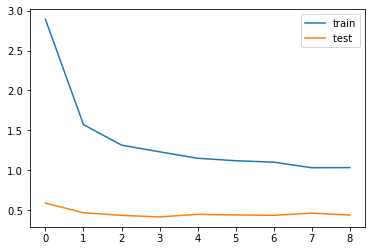

In [15]:
plt.plot(history_tr_ag.history['loss'], label = "train")
plt.plot(history_tr_ag.history['val_loss'], label = "test ")

plt.legend()
plt.show()

 - Looking at the val_loss graph I can assume that there is no overfitting - good sign.
 - Right now I want to see if my model does well on test data that I have as well from Kaggle.


In [57]:
test_generator = test_datagen.flow_from_directory(r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\pumba',
                                                        target_size=(h, w), 
                                                        batch_size=batch_size,
                                                        class_mode='categorical')

Found 6 images belonging to 1 classes.


In [58]:
test_inception = model_transfer.predict(test_generator)

In [26]:
np.save('test_inception_v1.npy', test_inception)

In [27]:
test_inception = np.load('test_inception_v1.npy')

In [86]:
prediction = model_transfer.predict(test_generator, verbose=1)

1/1 [==============================] - 3s 3s/step


In [80]:
prediction = pd.DataFrame(prediction)
prediction

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,3.217894e-03,4.869884e-04,6.682963e-05,8.756140e-06,9.608245e-05,4.314232e-07,5.349559e-05,5.656797e-06,4.104435e-05,4.227880e-05,...,2.167428e-05,7.484824e-06,7.803908e-06,7.739705e-05,4.763201e-06,2.390453e-06,4.895599e-05,7.085338e-05,2.977380e-06,3.729006e-04
1,6.872820e-09,5.542184e-10,3.790341e-07,2.107423e-06,3.689237e-06,4.504085e-06,3.655150e-05,2.073157e-06,1.205045e-08,3.390795e-08,...,1.598642e-06,4.137602e-02,4.088215e-08,8.888624e-10,1.298067e-06,3.979225e-08,6.004985e-08,9.690802e-06,5.698354e-09,7.909001e-08
2,9.756055e-07,1.011650e-05,1.999445e-08,3.896434e-08,2.850367e-06,4.023018e-09,3.624645e-08,1.464564e-06,2.242552e-04,9.678686e-01,...,1.736097e-09,1.156354e-07,1.671152e-06,6.399160e-05,3.535468e-09,9.621357e-11,5.874204e-09,3.937876e-09,1.016653e-06,1.307814e-07
3,7.161089e-08,6.707627e-07,8.697541e-11,4.015978e-09,4.617534e-07,2.027672e-07,1.475363e-07,8.554341e-07,9.998246e-01,1.607428e-05,...,6.443189e-08,1.681805e-06,1.857372e-09,4.784415e-06,2.484809e-09,1.528524e-08,8.310474e-09,9.267058e-10,3.482590e-07,1.189676e-08
4,5.942151e-11,4.152452e-12,3.042135e-14,2.750015e-09,3.007736e-11,1.494985e-11,9.054241e-10,3.475570e-12,6.886228e-09,4.377355e-12,...,1.730777e-09,4.771425e-09,9.167423e-13,8.083409e-12,2.633499e-09,7.393468e-13,6.571423e-13,1.217004e-12,1.285476e-13,4.677551e-12
5,5.182235e-07,4.668689e-06,6.410057e-06,3.604926e-07,2.377139e-07,4.557484e-07,4.359146e-07,8.030613e-07,1.696233e-08,8.419209e-08,...,3.311915e-05,4.194717e-07,2.857865e-07,3.779253e-09,4.406746e-07,1.270962e-06,1.034033e-07,1.987866e-07,3.801282e-08,1.457368e-07


In [83]:
breed_list.sort()
breed_list

['affenpinscher',
 'afghan_hound',
 'african_hunting_dog',
 'airedale',
 'american_staffordshire_terrier',
 'appenzeller',
 'australian_terrier',
 'basenji',
 'basset',
 'beagle',
 'bedlington_terrier',
 'bernese_mountain_dog',
 'black-and-tan_coonhound',
 'blenheim_spaniel',
 'bloodhound',
 'bluetick',
 'border_collie',
 'border_terrier',
 'borzoi',
 'boston_bull',
 'bouvier_des_flandres',
 'boxer',
 'brabancon_griffon',
 'briard',
 'brittany_spaniel',
 'bull_mastiff',
 'cairn',
 'cardigan',
 'chesapeake_bay_retriever',
 'chihuahua',
 'chow',
 'clumber',
 'cocker_spaniel',
 'collie',
 'curly-coated_retriever',
 'dandie_dinmont',
 'dhole',
 'dingo',
 'doberman',
 'english_foxhound',
 'english_setter',
 'english_springer',
 'entlebucher',
 'eskimo_dog',
 'flat-coated_retriever',
 'french_bulldog',
 'german_shepherd',
 'german_short-haired_pointer',
 'giant_schnauzer',
 'golden_retriever',
 'gordon_setter',
 'great_dane',
 'great_pyrenees',
 'greater_swiss_mountain_dog',
 'groenendael',


In [84]:
prediction.columns = breed_list

In [87]:
y_classes = prediction.argmax(axis=-1)
y_classes

array([ 88,   8,  20,   9,  75, 105], dtype=int64)

In [99]:
from PIL import Image

Model prediction: pug


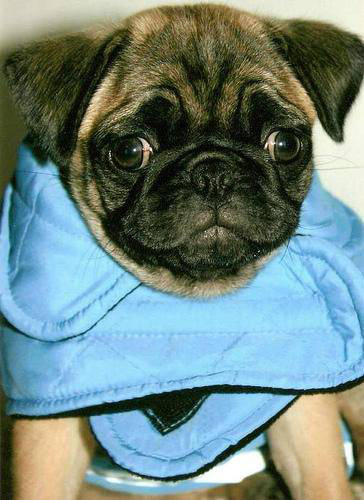

In [114]:
print(f'Model prediction: {breed_list[y_classes[0]]}')
Image.open(r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\pumba\aaa\4.jpg')

Model prediction: basset


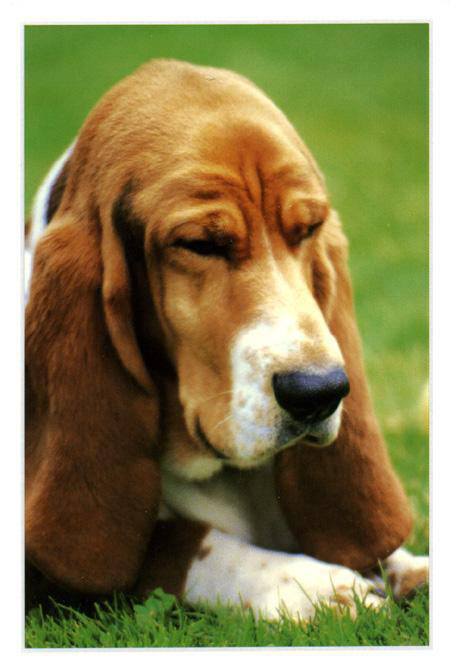

In [115]:
print(f'Model prediction: {breed_list[y_classes[1]]}')
Image.open(r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\pumba\aaa\6.jpg')

Model prediction: bouvier_des_flandres


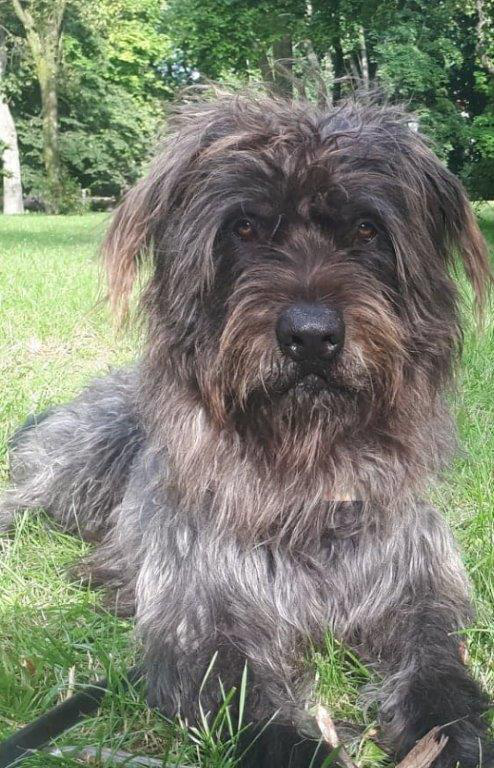

In [116]:
print(f'Model prediction: {breed_list[y_classes[2]]}')
Image.open(r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\pumba\aaa\1.jpg')

Model prediction: beagle


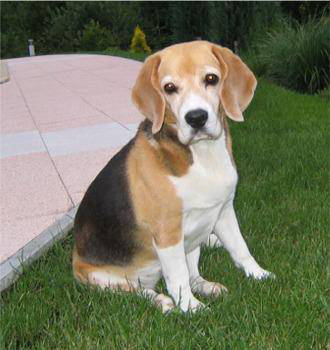

In [117]:
print(f'Model prediction: {breed_list[y_classes[3]]}')
Image.open(r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\pumba\aaa\3.jpg')

Model prediction: miniature_pinscher


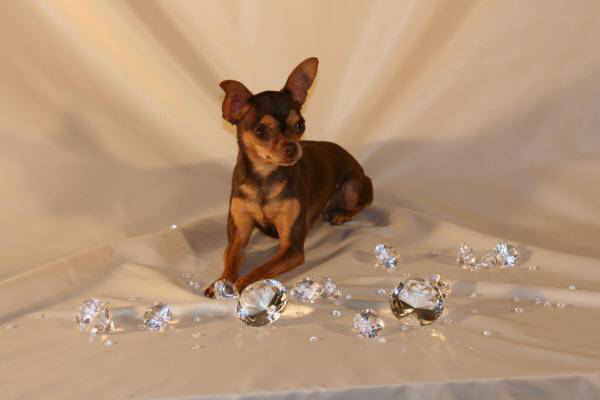

In [118]:
print(f'Model prediction: {breed_list[y_classes[4]]}')
Image.open(r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\pumba\aaa\2.jpg')

Model prediction: standard_poodle


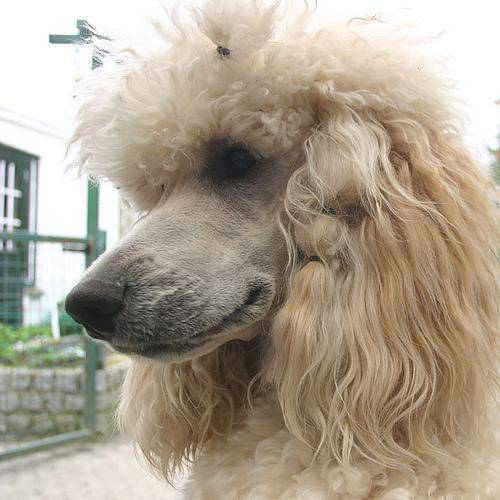

In [119]:
print(f'Model prediction: {breed_list[y_classes[5]]}')
Image.open(r'C:\Users\Jakub\Desktop\Projekt Dog Breed\dog-breed-identification\pumba\aaa\5.jpg')